# 配对交易策略研究
#### @Author  : 赵勇（译自Quantopian Lecture Series）

---

配对交易是一种基于数学的方法分析的策略。

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j], score, pvalue))
    return score_matrix, pvalue_matrix, pairs

In [3]:
symlist = ["AU00.SHF","CF00.CZC", "CU00.SHF", "J00.DCE",
           "L00.DCE","P00.DCE", "RB00.SHF","RU00.SHF",
           "SR00.CZC","M00.DCE"]
prices_df = pd.DataFrame()
for i in symlist:
    df = pd.read_csv('../winddata/'+i+'.csv', index_col=0)
    df_close = df[(df.index >= '2012-09-20') & (df.index <= '2016-09-20')]['CLOSE']
    prices_df = pd.concat([prices_df,df_close],axis=1)
prices_df.columns = symlist

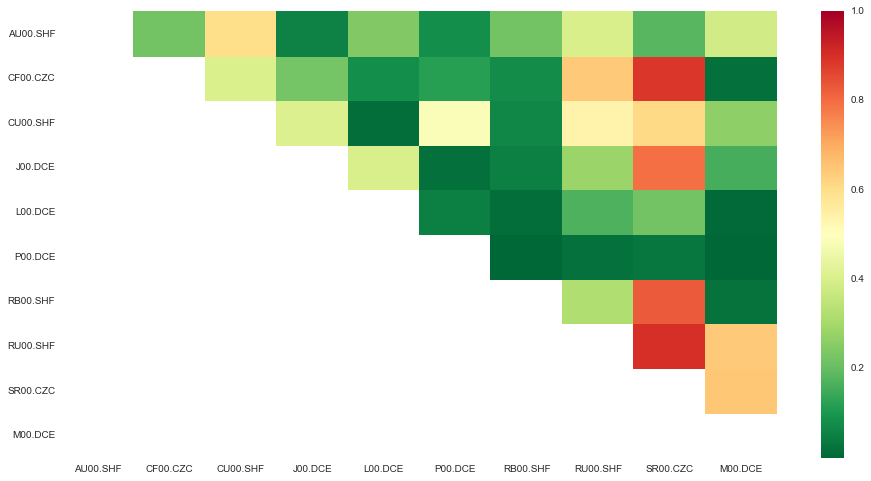

In [4]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(prices_df)
import seaborn
plt.figure(figsize=(16,8))
seaborn.heatmap(pvalues, xticklabels=symlist, yticklabels=symlist, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.95)
                )

In [5]:
p = pd.DataFrame(pairs,columns=['S1','S2','Pvalue','Score'])
p

,S1,S2,Pvalue,Score
0,CF00.CZC,M00.DCE,-3.718078,0.017367
1,CU00.SHF,L00.DCE,-3.841031,0.011941
2,J00.DCE,P00.DCE,-3.715821,0.017485
3,J00.DCE,RB00.SHF,-3.356293,0.047442
4,L00.DCE,P00.DCE,-3.357124,0.047341
5,L00.DCE,RB00.SHF,-3.838425,0.012038
6,L00.DCE,M00.DCE,-4.114108,0.004904
7,P00.DCE,RB00.SHF,-5.000497,0.000164
8,P00.DCE,RU00.SHF,-3.644021,0.021590
9,P00.DCE,SR00.CZC,-3.506375,0.031834


In [6]:
S2 = prices_df['P00.DCE']
S1 = prices_df['SR00.CZC']
##转换时间戳
tdate = map(lambda x:datetime.strptime(x[:-4], '%Y-%m-%d %H:%M:%S').date(),
                    S1.index.values)
S1.index = tdate
S2.index = tdate

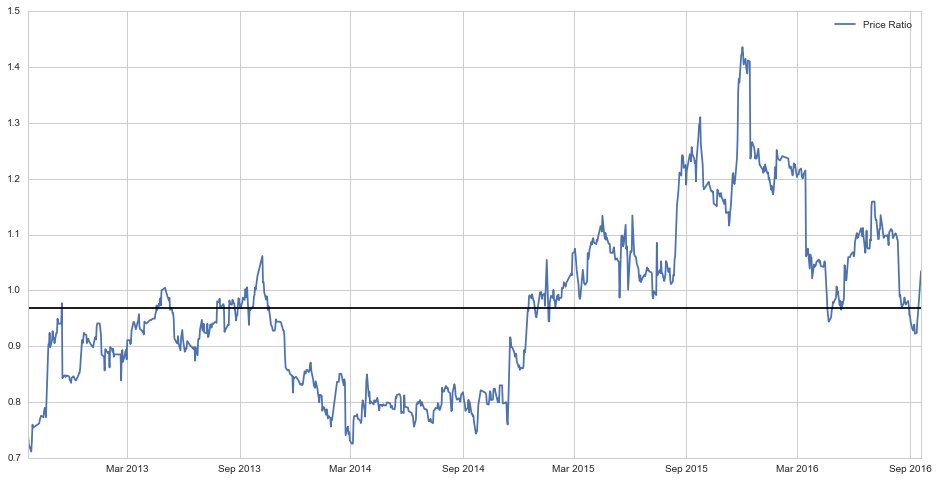

In [7]:
ratio = S1/S2
plt.figure(figsize=(16,8))
ratio.plot()
plt.axhline(ratio.mean(), color='black')
plt.legend(['Price Ratio']);

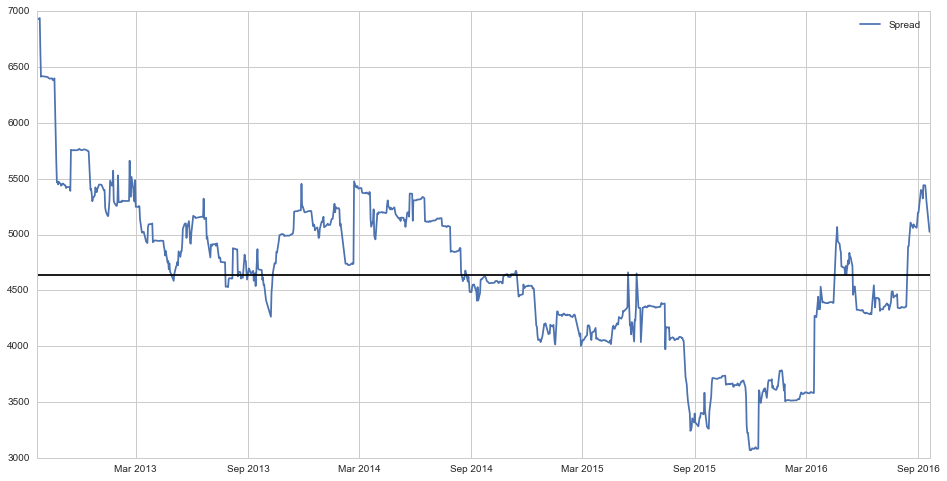

In [9]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['SR00.CZC']
b = results.params['SR00.CZC']

spread = S2 - b * S1
plt.figure(figsize=(16,8))
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

&emsp; &emsp; 价比配对是传统的处理方式，因为我们假设的是价格序列服从对数正态分布。然而得到精确的价比也许不那么适用
“This can be a little irritating to deal with for our purposes as purchasing the precisely correct ratio of a trading pair may not be practical.”。我们要选择用线性回归得到的价差。关于区别，如果两个配对的资产不实真正的协整，但是你相信他们的价差短期内仍然会回归均值，用价比会比价差或者对数价差更好。回到例子，决定价差在统计中用处不大，还需要对其做标准化处理。 

In [10]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

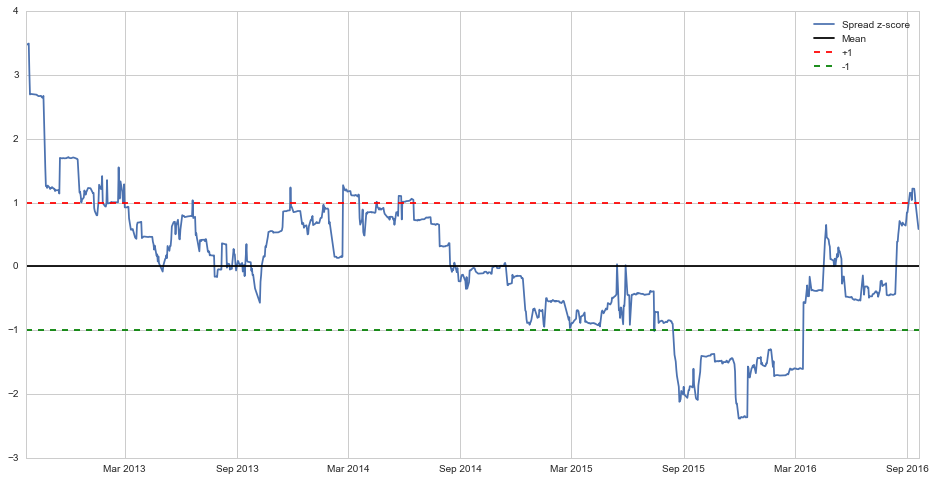

In [11]:
plt.figure(figsize=(16,8))
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

### 简单的策略逻辑： 
* 当z-score小于 -1.0,做多价差
* 当z-score大于 1.0,做空价差
* 当z-score达到 0,出场  
##### 或者可以这样：
* 在-1.0,1.0处出场

## 不断更新统计指标（计算移动指标）
&emsp; &emsp; 要用滚动数据替代原始数据，比如用移动平均价

## 移动平均

In [13]:
window = 30
beta = np.zeros(len(S1)+1-window)
for t in range(len(S1)+1-window):
    S1 = sm.add_constant(S1)
    results = sm.OLS(S2[t:t+window], S1[t:t+window]).fit()
    S1 = S1['SR00.CZC']
    b = results.params['SR00.CZC']
    beta[t] = b
rolling_beta = pd.Series(beta,index=S1[window-1:].index)

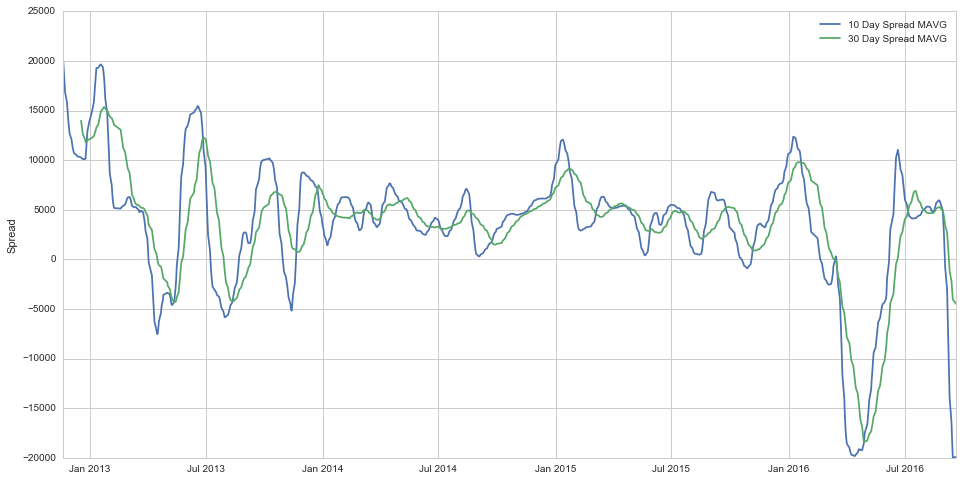

In [14]:
# Get the spread between the 2 stocks
# Calculate rolling beta coefficient,估计滚动的beta。
### 不要用pd.ols，改为之前的回归加上滚动
#rolling_beta = pd.ols(y=S2, x=S1, window_type='rolling', window=30)
spread = S2 - rolling_beta * S1
spread.name = 'spread'

# 替换：Series.rolling(window=1,center=False).mean()
# Get the 1 day moving average of the price spread
spread_mavg10 = spread.rolling(window=10,center=False).mean()
spread_mavg10.name = 'spread 1d mavg'

# Get the 30 day moving average
spread_mavg30 = spread.rolling(window=30,center=False).mean()
spread_mavg30.name = 'spread 30d mavg'

plt.figure(figsize=(16,8))

plt.plot(spread_mavg10.index, spread_mavg10.values)
plt.plot(spread_mavg30.index, spread_mavg30.values)

plt.legend(['10 Day Spread MAVG', '30 Day Spread MAVG'])

plt.ylabel('Spread');


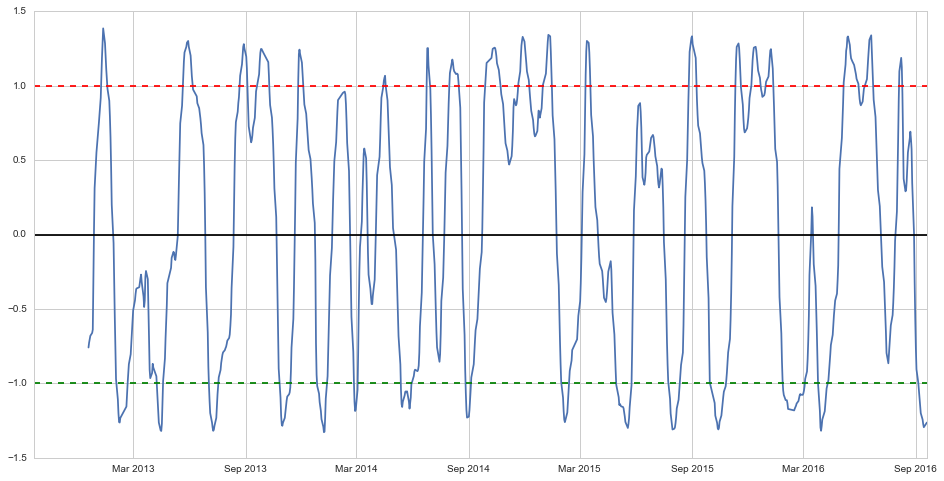

In [15]:
# Take a rolling 30 day standard deviation
std_30 = spread.rolling(window=30).std()
std_30.name = 'std 30d'

# Compute the z score for each day
zscore_30_1 = (spread_mavg10 - spread_mavg30)/std_30
zscore_30_1.name = 'z-score'

plt.figure(figsize=(16,8))
zscore_30_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')

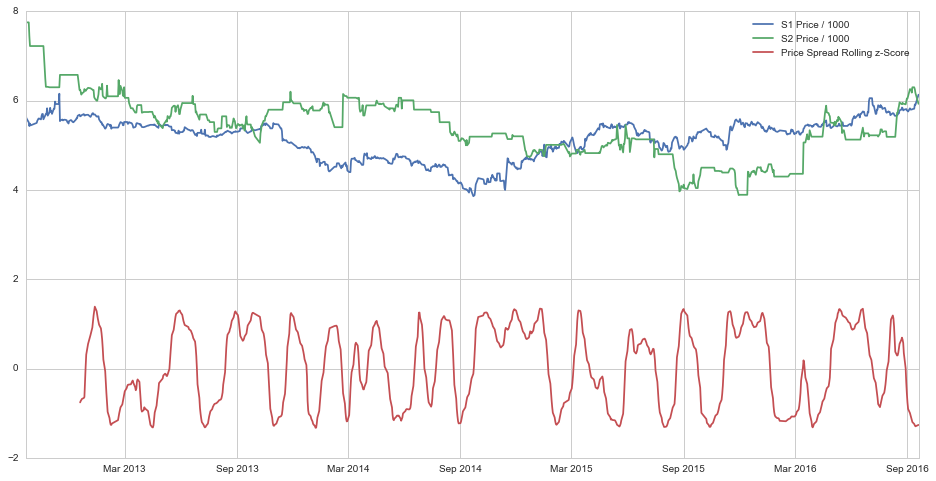

In [16]:
plt.figure(figsize=(16,8))
plt.plot(S1.index, S1.values/1000)
plt.plot(S2.index, S2.values/1000)
plt.plot(zscore_30_1.index, zscore_30_1.values)
plt.legend(['S1 Price / 1000', 'S2 Price / 1000', 'Price Spread Rolling z-Score']);